<a href="https://colab.research.google.com/github/RichBirch1/RichBirch1/blob/main/M%26V_Summative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook Details

This Jupyter Notebook was developed in Google Colab. Its purpose is to find a suitable model for predicting credit card fraud using a test data set that contain 2 days' data from 13/14 Oct 2020.

The data is imported and investigated for potential discrepancies and anomalies before checking the descriptive statistics and looking for patterns and correlations between fraud and the other data features.

Features for the model are selected and the data set is split in to training and testing sets and the training set used to train multiple predictive models.

Some models will be tuned to increase accuracy and results compared based on the loss function.

# 1 - Load libraries to be used in the notebook

In [ ]:
# Install Sweetviz EDA using pip.  This will be used for EDA.
! pip install Sweetviz

In [ ]:
# Import the libraries we will be using in the notebook for data manipulation and visualisations
import numpy as np
import pandas as pd
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh as bk

print('Libraries Imported')

Libraries Imported


# 2 - Load the files in to the environment

In [ ]:
# Import the Credit Card Data file
#from google.colab import files
#uploaded = files.upload()

In [ ]:
# Create a dataframe object that contains the Credit Card dataset and check the size of the dataframe
# (In Excel this is 100,000 rows x 15 columns)
df = pd.read_csv('CreditCardData.csv')
df.shape

(100000, 15)

#3 - Data Exploration

In [ ]:
# Check for any missing data in the file, these may need to be replaced by averages or incomplete records may need to be removed to avoid skewing the predictive model.
df.isnull().sum()

Transaction ID            0
Date                      0
Time                      0
Type of Card              0
Entry Mode                0
Amount                    0
Type of Transaction       0
Merchant Group            0
Country of Transaction    0
Shipping Address          0
Country of Residence      0
Gender                    0
Age                       0
Bank                      0
Fraud                     0
dtype: int64

In [ ]:
# Duplicate records can also skew any predcive models.  Check for duplicated records in the data set.
dfdup = df[df.duplicated()]
dfduplen = len(dfdup)
print('There are', dfduplen, 'duplicated records')

There are 0 duplicated records


In [ ]:
# Check the column names and data types for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Transaction ID          100000 non-null  object
 1   Date                    100000 non-null  object
 2   Time                    100000 non-null  int64 
 3   Type of Card            100000 non-null  object
 4   Entry Mode              100000 non-null  object
 5   Amount                  100000 non-null  object
 6   Type of Transaction     100000 non-null  object
 7   Merchant Group          100000 non-null  object
 8   Country of Transaction  100000 non-null  object
 9   Shipping Address        100000 non-null  object
 10  Country of Residence    100000 non-null  object
 11  Gender                  100000 non-null  object
 12  Age                     100000 non-null  int64 
 13  Bank                    100000 non-null  object
 14  Fraud                   100000 non-nu

In [ ]:
# Check how the data looks
df.head()

Transaction ID       Date  Time Type of Card  ... Gender Age      Bank Fraud
0      #2546 884  13-Oct-20    23   MasterCard  ...      F  36  Barclays     0
1      #2546 895  14-Oct-20    21         Visa  ...      M  41       RBS     0
2      #2546 903  13-Oct-20    19         Visa  ...      M  32  Barclays     0
3      #2546 906  14-Oct-20     9   MasterCard  ...      F  65  Barclays     0
4      #2546 920  13-Oct-20    22         Visa  ...      F  61     Monzo     0

[5 rows x 15 columns]

*  'Amount' is designated an 'object' type (text) because it contains the '£' character prefix.  This should be changed to a numerical data type since it is a continuous variable.
*  The 'Transaction ID' values appear to be unnecessary so can be removed from the data set before analysis and modelling

In [ ]:
# Remove Transaction ID as this is just a unique record key
del df['Transaction ID']

In [ ]:
# Check the number and percentage of fraudulent transaction in the data set 
fraud = df['Fraud'].sum() / len(df)
fraudcnt = df['Fraud'].sum()

print('Percentage of Card transactions that are fraudulent:', fraud * 100,'%','of', len(df))

Percentage of Card transactions that are fraudulent: 7.19 % of 100000


In [ ]:
# Check the number of dates and corresponding Fraud day to see if either has siginifcantly more
df.groupby(['Date', 'Fraud']).agg(RecordCount=('Fraud', 'count'))

RecordCount
Date      Fraud             
13-Oct-20 0            46081
          1             3733
14-Oct-20 0            46729
          1             3457

Since there are only 2 dates and the Fraud amount is spread quite evenly across the dates, this will not be of much value in the modelling and can now be removed.
If there had been more dates may have been useful to check if specific days of the week were prone to higher fraud rates.

In [ ]:
# Delete the Date column from the dataframe
del df['Date']

In [ ]:
# Create a list of the column names that can be used as features in the model
list(df)

['Time',
 'Type of Card',
 'Entry Mode',
 'Amount',
 'Type of Transaction',
 'Merchant Group',
 'Country of Transaction',
 'Shipping Address',
 'Country of Residence',
 'Gender',
 'Age',
 'Bank',
 'Fraud']

In [ ]:
# Inspect the categorical features in the data by checking the values

# Create the features object
features = list(df)

# Remove the non categorical features Age and Amount from the features object before getting the values
features.remove('Amount')
features.remove('Age')

# Show the value counts for each feature:
for i in features:
  j = df[i].value_counts()
  print("---- %s ---" % i)
  print(j)

---- Time ---
16    5786
23    5757
12    5757
11    5751
7     5720
13    5700
21    5689
15    5688
14    5688
8     5683
17    5669
19    5631
22    5625
10    5610
9     5576
18    5553
20    5522
2      546
3      543
6      526
0      506
5      497
1      495
4      482
Name: Time, dtype: int64
---- Type of Card ---
Visa          53812
MasterCard    46188
Name: Type of Card, dtype: int64
---- Entry Mode ---
PIN    50163
Tap    49837
Name: Entry Mode, dtype: int64
---- Type of Transaction ---
Online    33482
ATM       33275
POS       33243
Name: Type of Transaction, dtype: int64
---- Merchant Group ---
Children         10681
Restaurant       10078
Services         10017
Gaming           10012
Fashion           9989
Subscription      9978
Food              9850
Products          9840
Entertainment     9840
Electronics       9715
Name: Merchant Group, dtype: int64
---- Country of Transaction ---
United Kingdom    71200
USA                7298
Russia             7257
China          

The above record counts show that there is a fairly even split for records across most features, although there are some features that are not.
* Time has around a 10th of the records in the first quarter of the day compared to the rest of the day
* United Kindom has by far the most records for all location features
* Barclays has the most transactions of all banks but also appears to be spelled incorrectly for 9993 records.  This needs to be fixed.

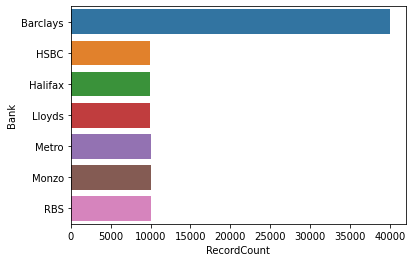

In [ ]:
# Replace the incorrect spelling 'Barlcays' with 'Barclays'
df['Bank'].replace(to_replace='Barlcays',value='Barclays', inplace=True, limit=False)
# Check the record counts per Bank now the data is cleansed and create a horizontal bar to view
sns.barplot( data = df.groupby(['Bank']).agg(RecordCount=('Bank','count')).reset_index(), x = 'RecordCount', y = 'Bank' );

In [ ]:
# Convert the currency strings to integers where they contain the £ sign
df['Amount'] = df['Amount'].replace({'£':''}, regex = True)
df['Amount'] = df['Amount'].astype(int)
df.head(1)

Time Type of Card Entry Mode  Amount  ... Gender Age      Bank Fraud
0    23   MasterCard        Tap      17  ...      F  36  Barclays     0

[1 rows x 13 columns]

In [ ]:
# Use sweetviz and specify the target_feat parameter to see how each feature correlates to Fraud.
my_report = sv.analyze(df, target_feat ='Fraud')
my_report.show_html()

The Sweetviz report shows the following:
* Time has a small correlation with Fraud
* An 8% higher percentage of fraud occurs from the 'Tap' Entry Mode than PIN
* Entry Mode also has a high correlation with Amount
* The Children, Electronics and Fashion merchant groups are the highest percentage of Fraud
* Online transaction have an above average fraud percentage
* United Kingdom has around 1% fraudulent transactions compared to 20% in all other countries
* There are differences between the country of transaction, shipping and residence that may be worth investigating for feature development



In [ ]:
# Group by Time then count and sum the Fraud values, this gives 2 values for a stacked bar chart
dftime = df.groupby(['Time']).agg(RecordCount=('Fraud', 'count'), TotalFraud=('Fraud', 'sum'))
dftime['Fraud%'] = (dftime['TotalFraud'] / dftime['RecordCount'])

# Reset the Index to make sure the Time column is included in the data frame
dftime = dftime.reset_index()
dftime.head(10)

Time  RecordCount  TotalFraud    Fraud%
0     0          506         506  1.000000
1     1          495         495  1.000000
2     2          546         546  1.000000
3     3          543         543  1.000000
4     4          482         482  1.000000
5     5          497         497  1.000000
6     6          526         526  1.000000
7     7         5720         211  0.036888
8     8         5683         196  0.034489
9     9         5576         209  0.037482

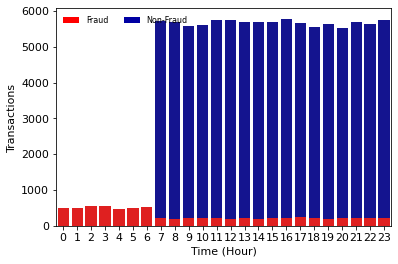

In [ ]:
# Create a stacked bar chart to understand the amount of Fraud to non-Fraud ratio 

# Plot 1 - background - "total" (top) series
sns.barplot(x = dftime.Time, y = dftime.RecordCount, color = "#0000A3")
# Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = dftime.Time, y = dftime.TotalFraud, color = "red")

topbar = plt.Rectangle((0,0),1,1,fc="#0000A3", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='red',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Fraud', 'Non-Fraud'], loc=0, ncol = 2, prop={'size':8})
l.draw_frame(False)

# Label the chart
bottom_plot.set_ylabel("Transactions")
bottom_plot.set_xlabel("Time (Hour)")

#Set fonts to consistent 11pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(11)

The Time chart shows that all transactions between midnight and 6am are fraudulent and the rate is higher than at other times.

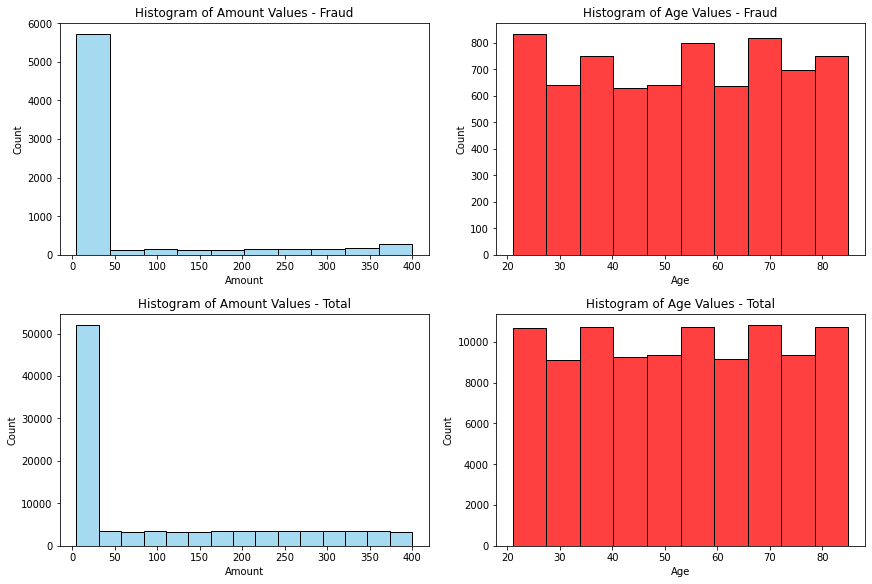

In [ ]:
# Visualise the Age and Amount features in a set of histogram charts

# Set up the 2x2 chart subplots and size, use constrained layout to ensure lables do not overlap
fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

# Create the charts and axis labels
sns.histplot(data=df.loc[df["Fraud"] == True], x="Amount", color="skyblue", kde=False, bins=10, ax=axs[0,0])
sns.histplot(data=df, x="Amount", color="skyblue", kde=False, bins=15, ax=axs[1,0])
sns.histplot(data=df.loc[df["Fraud"] == True], x="Age", color="red", kde=False, bins=10, ax=axs[0,1])
sns.histplot(data=df, x="Age", color="red", kde=False, bins=10, ax=axs[1,1])

# Add chart titles for each histogram
axs[0,0].title.set_text('Histogram of Amount Values - Fraud')
axs[1,0].title.set_text('Histogram of Amount Values - Total')
axs[0,1].title.set_text('Histogram of Age Values - Fraud')
axs[1,1].title.set_text('Histogram of Age Values - Total')
plt.show()

The chart shows that lower Amounts are much more common overall and there is a fairly even spread of ages, to which fraud is also equally spread.

# Data Preprocessing

In [ ]:
# Create a copy of the data to for manupilatiion of features and conversion of catagorical text values to numerical values for modelling
df2 = df.copy()

Age and Amount values are quite spread out so we will normalise the numeric data using MinMax scaling

In [ ]:
# Normalise the Amount values
df2['AmountScl'] = (df2['Amount'] - df2['Amount'].min()) / (df2['Amount'].max() - df2['Amount'].min())

# Normalise the Age values
df2['AgeScl'] = (df2['Age'] - df2['Age'].min()) / (df2['Age'].max() - df2['Age'].min())

# Check the new values in for Amount and Age
print('This min and max Amount values in the scale are now', df2['AmountScl'].min(), 'and', df2['AmountScl'].max())
print('This min and max Age values in the scale are now', df2['AgeScl'].min(), 'and', df2['AgeScl'].max())

This min and max Amount values in the scale are now 0.0 and 1.0
This min and max Age values in the scale are now 0.0 and 1.0


The histogram shows there is no central tendency toward specific ages, they are quite evenly distributed.

In [ ]:
# Convert the features to values using the label encoder ready for modelling
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for i in features:
  df2[i] = le.fit_transform(df2[i])

I suspect that there may be a higher amount of Fraud seen when the country of residence is different to the shipping or transaction address.  This is something that can be checked by creating new columns that indicate whether the addresses are different (1=True - they do differ, 0=False - they are the same)

In [ ]:
# Create new feature for different shipping location to country of residence location
df2['diff_ship_add'] = df2['Country of Residence'] - df2['Shipping Address']

# Create new feature for different transaction location to country of residence location
df2['diff_tran_add'] = df2['Country of Residence'] - df2['Country of Transaction']

# Convert the values to boolean (1=true, 0=false)
df2['diff_ship_add'] = df2['diff_ship_add'].astype(bool).astype(int) 
df2['diff_tran_add'] = df2['diff_tran_add'].astype(bool).astype(int)

In [ ]:
# Now we have the difference indicator columns, the original columns can be dropped
del df2['Shipping Address']
del df2['Country of Transaction']
del df2['Age']
del df2['Amount']

In [ ]:
# Check the layout of the data after the changes are applied
df2.head(1)

Time  Type of Card  Entry Mode  ...    AgeScl  diff_ship_add  diff_tran_add
0    23             0           1  ...  0.234375              1              0

[1 rows x 13 columns]

In [ ]:
# Inspect the new features
features2 = list(['diff_ship_add','diff_tran_add'])

#features2.append(df['diff_ship_add'])
#features2.append(df['diff_tran_add'])

# Show the value counts for each feature:
for i in features2:
  j2 = df2[i].value_counts()
  print("---- %s ---" % i)
  print(j2)

---- diff_ship_add ---
0    77287
1    22713
Name: diff_ship_add, dtype: int64
---- diff_tran_add ---
0    89340
1    10660
Name: diff_tran_add, dtype: int64


In [ ]:
dfshipdiff = df2.groupby('diff_ship_add').agg(RecordCount=('Fraud', 'count'), TotalFraud=('Fraud', 'sum'))
dfshipdiff['Fraud%'] = (dfshipdiff['TotalFraud'] / dfshipdiff['RecordCount'])
dfshipdiff

RecordCount  TotalFraud    Fraud%
diff_ship_add                                   
0                    77287           3  0.000039
1                    22713        7187  0.316427

The number of fraudulent transactions is heavily weighted to transaction that have a different shipping address to the Country of Residence

In [ ]:
# Filter for the values where transaction was Fraudulent and Shipping address matched the Country of Transaction
df.loc[(df2["Fraud"] == True) & ( df2["diff_ship_add"] == False)]

Time Type of Card Entry Mode  Amount  ... Gender Age      Bank Fraud
59090    17         Visa        Tap      20  ...      M  23  Barclays     1
66959    12         Visa        Tap       6  ...      M  22  Barclays     1
99572     9         Visa        Tap      12  ...      M  23     Metro     1

[3 rows x 13 columns]

Only this tiny amount of transactions took place where shipping was in the same country as residence and the 3 records show all were contactless payments for items in the Children Merchant group with ages being almost the same each time.

In [ ]:
# Show the total records, how many are Fraud and te percentage that are Fraud
dftrandiff = df2.groupby('diff_tran_add').agg(RecordCount=('Fraud', 'count'), TotalFraud=('Fraud', 'sum'))
dftrandiff['Fraud%'] = round(dftrandiff['TotalFraud'] / dftrandiff['RecordCount']*100, 1)
dftrandiff

RecordCount  TotalFraud  Fraud%
diff_tran_add                                 
0                    89340        1189     1.3
1                    10660        6001    56.3

In [ ]:
# Re-arrange the columns in the dataframe to help with readability

df2 = df2[['Fraud','Time', 'Gender', 'AgeScl', 'Bank', 'Type of Card', 'Entry Mode', 'AmountScl',
           'Type of Transaction', 'Merchant Group', 'Country of Residence', 'diff_tran_add', 'diff_ship_add']]

In [ ]:
# Check how the data looks after the previous processing steps have completed
df2.head()

Fraud  Time  Gender  ...  Country of Residence  diff_tran_add  diff_ship_add
0      0    23       0  ...                     4              0              1
1      0    21       1  ...                     4              0              0
2      0    19       1  ...                     4              0              0
3      0     9       0  ...                     4              0              0
4      0    22       0  ...                     4              0              0

[5 rows x 13 columns]

In [ ]:
# Create and display the correlation matrix for values in the data to see which features corrolate positively and negatively
corr = df2.corr()
corr

Fraud      Time  ...  diff_tran_add  diff_ship_add
Fraud                 1.000000 -0.288598  ...       0.656622       0.513155
Time                 -0.288598  1.000000  ...      -0.192224      -0.148066
Gender                0.047540 -0.015569  ...       0.001394      -0.000463
AgeScl               -0.000867 -0.001760  ...       0.004791       0.005941
Bank                 -0.005154  0.006118  ...      -0.003948      -0.001278
Type of Card          0.034703 -0.014935  ...      -0.001193       0.001182
Entry Mode            0.152347 -0.041731  ...      -0.000948       0.003366
AmountScl            -0.110096  0.030199  ...       0.003505       0.001379
Type of Transaction   0.030676 -0.009388  ...      -0.002447       0.001559
Merchant Group       -0.069044  0.020335  ...      -0.003385      -0.004015
Country of Residence  0.105997 -0.028911  ...       0.145584       0.180087
diff_tran_add         0.656622 -0.192224  ...       1.000000       0.637194
diff_ship_add         0.513155 -0.148066  ...       0.637194       1.000000

[13 rows x 13 columns]

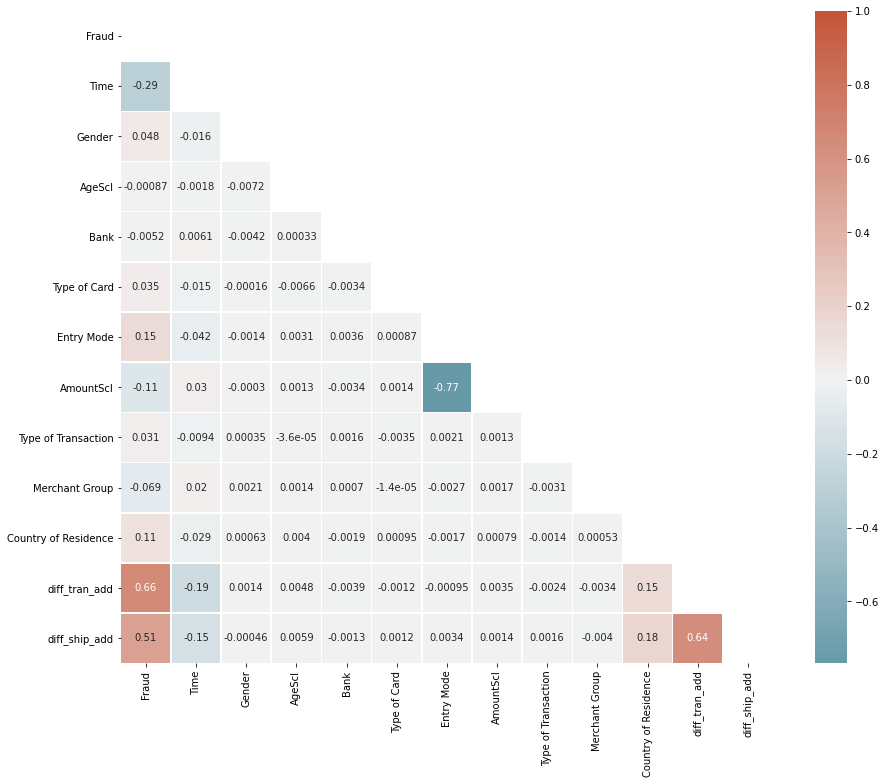

In [ ]:
# Display the correlation matrix chart with the darker colour assigned to higher correlation values

# Set the masked sections of the chart to make it less confusing to read 
mask = np.triu(np.ones_like(corr, dtype=bool))

#Set the colour mapping to a diverging palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Set the chart size
f, ax = plt.subplots(figsize=(15,12))

# Plot the chart and the colour range as subplots, including the mask and cmap setting above
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, annot=True);

The Age (AgeScl) and Bank features have very small correlation with Fraud or any of the other features, the absolute values are below.  Removing these may be helpful to speed up the model.

In [ ]:
# To prepare for modelling, create the X data set with the Fraud column removed
X = df2.drop('Fraud', axis=1)
# Create the y data set using only the Fraud column
y = df2['Fraud']

# Modelling

**Cost function options:**
* **Mean Absolute Error (MAE):** This measures the absolute average distance between the real data and the predicted data, but it fails to punish large errors in prediction.

* **Mean Squared Error (MSE):** The 'Squared Error' (loss function) applies to individual training data points and is the square of the difference between the actual data point and its predicted value.  The 'Mean Squared Error' (called cost function because it's on the full data) is the squared average distance between the real data and the predicted data. Squaring the errors ensures negative distances don't cancel out positive distances.  Squaring the errors means that larger errors, like those from outliers, are penalised more than smaller ones in the training data, so these either need to be handled in the pre-processing stage or it should be considered

*  **Root Mean Squared Error (RMSE):** This is the square root of the MSE.  It metrics solves the problem of squaring the units.  The lower the value, the more accurate the model's predictions are.

When creating multiple models, scoring can be used to compare how well each performed. Note that the results are likely to change each time the model is trained, since we randomly assign values when we build it.

**Bias / Variance Trade-off**
* Bias is the difference between predictions and actuals in supervised ML
* Variance measures the consistency of the predictor across training and testing data sets
* Inducible error is the amount of noise

It's important to strike a balance between accuracy and variance.  We need to find the sweet spot between simple and complex models to avoid over-fitting (low bias, high variance) or under-fitting (high bias, low variance) to the training data.

Ensemble methods like 'Boosting' and 'Bagging' are commonly used to find the sweet spot by reducing bias and variance to make more reliable models.  We will use a selection of these and compare the results to find the best model.


**Models To Test**

Single models:
* Logistic Regression

  Logistic regression is the classification counterpart to linear regression, which looks to fit a straight line (i.e. linear) to the data set. Linear models work well for linear relationships in data but can perform poorly when relationships are non-linear. Models can be easy to interpret and update, but are not good at predictions for complex relationships [2]


Ensemble Methods:

* Decision Tree Classifier

  This classifier is a great model to get a baseline prediction as it is one of the easier models in terms of explainability.  It weights features to create a single tree structure to classify the data samples.  These models are better at capturing non-linear relationships and coping with outliers, but the can be prone to over-fitting if not constrained.

* Bootstrap Aggregating ('Bagging') Models:
  * Bagging Classifier:

    Increases model accuracy using multiple decision trees that largely reduce variance to reduce over-fitting [1].  These models are less prone to over-fitting than individual decision trees as they aggregate the individual learners. Using many trees can consume a lot of computation power. [4]

  * Random Forest Classifier:
  
    A parallel technique, base learners generated in parallel, independence between learners significantly reduces error due to averages being applied [1].  Random Forests are good at reducing over-fitting and don't require feature normalisation, but they are not easy to interpret. [5]

* Boosting models:

  These learn from previous predictor mistakes to make better predictions in the future.

  * Adaptive Boosting ('AdaBoost'):
  
    A sequential technique where base learners are generated in sequence, takes account of weak learners in the form of many 'one split' (usually) decision trees, normally referred to as 'stumps'. Some stumps more heavily weighted in the classification and each stump is made by accounting for the previous stump's inaccuracy. [1]  The model is easy to implement with no parameters to adjust, but it can be sensitive to outliers. [6]

  * Extreme Gradient Boosting ('XGBoost'):

    Again, this model uses decision trees but nodes in every decision tree take a different subset of features for selecting the best split. The trees run sequentially and learn from the errors of the previous trees. It combines the predictions from all the trees to arrive at the final prediction.  The model can reduce overfitting versus the Gradient Boost and improve overall performance, but it has a number of parameters that may need to be set to get good accuracy.

Neural Networks:

* Artificial Neural Networks:

  Made up of interconnected neuron layers, each being a composite of many different regression equations that are used to classify objects.  After aggregating the results of each equations, it uses a feedback process called backpropagation that then effectively goes backwards from the output, through the (hidden) neuron layers, to the input layer where it takes the difference between what the output should be and what it was to modify the coefficients of the regression equations in the neurons until it finds the best fit to the data.  This makes them very good at identifying patterns in the data but also makes them hard to interpret and communicate [3].



**References**

[1] Corporate Finance Institute, (n.d.). *Ensemble Methods - Overview, Categories, Main Types*. [online] Available at https://corporatefinanceinstitute.com/resources/knowledge/other/ensemble-methods/.  (Accessed 1-May-2021)

[2] EliteDataScience, 2017. Modern Machine Learning Algorithms: Strengths and Weaknesses. [online] Available at: https://elitedatascience.com/machine-learning-algorithms. (Accessed 1-May-2021)

[3] Explain that Stuff, 2011. *How neural networks work - A simple introduction*. [online] Available at: https://www.explainthatstuff.com/introduction-to-neural-networks.html. (Accessed 1-May-2021)

[4] Paperspace Blog, 2020. *Introduction to Bagging and Ensemble Methods*. [online] Available at: https://blog.paperspace.com/bagging-ensemble-methods/. (Accessed 6-May-2021)

[5] Bahnsen, A., 2017. *Machine Learning Algorithms: Introduction to Random Forests*. [online] DATAVERSITY. Available at: https://www.dataversity.net/machine-learning-algorithms-introduction-random-forests/. (Accessed 7 May 2021)

[6] livebook.manning.com. (n.d.). *Chapter 7. Improving classification with the AdaBoost meta-algorithm · Machine Learning in Action*. [online] Available at: https://livebook.manning.com/book/machine-learning-in-action/chapter-7/7. (Accessed 7 May 2021)

In [ ]:
# Import the relevant libraries from scikit learn for spillting the data to test and train
from sklearn.model_selection import train_test_split
# Import the metrics library from SciKit Learn
from sklearn import metrics
# Import the confusion matrix library from metrics
from sklearn.metrics import confusion_matrix

In [ ]:
# Create the split X and y data sets using a random 70% for training the model and 30% for testing its accuracy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Logistic Regression Classifier

In [ ]:
# Import the Descion Tree classifier and metrics libraries
from sklearn.linear_model import LogisticRegression
print('LogisticRegression imported')

LogisticRegression imported


In [ ]:
# Create Linear Regression classifier model and pass in the X and y training data sets

# Train the model using the training features (X_train) and the actual labels (y_train)
logreg = LogisticRegression(max_iter=200)   # Include the number of iterations 
logreg.fit(X_train, y_train)

# Pass in the test data and make the predictions using the 
y_pred_LR = logreg.predict(X_test)

# Create the accuracy scores for Mean Square Error and Root Mean Square Error
# Assign the accuracy for the Decision Tree to acc_DT
acc_LR = metrics.accuracy_score(y_test, y_pred_LR)
# Assign the MSE score for the Decision Tree to mse_DT
mseLR = metrics.mean_squared_error(y_test, y_pred_LR)
# Assign the MSE score for the Decision Tree to rmse_DT
rmseLR = np.sqrt(mseLR)

In [ ]:
# Check the accuracy of the Logistic model
print('Logistic Regrssion classifier -  Accuracy:', 
      format(acc_LR, '.2%'), '  MSE:', round(mseLR,3), '  RMSE:', round(rmseLR,3))

Logistic Regrssion classifier -  Accuracy: 97.22%   MSE: 0.028   RMSE: 0.167


In [ ]:
# Check the results for the optimised tree
print("Logistic Regression Accuracy:", acc_LR)
print()

# Create a dataframe with the Actuals and Predictions
df_LR = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred_LR})
# Set the Predicted column as integer type
df_LR['Predicted'] = df_LR['Predicted'].astype(int)
# Create the results list for the table
results = ["True Negative","False Positive","False Negative","True Positive"]

# Group the data set by counting the number of values per column, add the results labels and re-order the columns
df_LR = df_LR.groupby(["Actual", "Predicted"]).size().reset_index(name="Count")
df_LR['Result'] = results 
df_LR = df_LR[["Result","Actual","Predicted","Count"]]
# Show the table
df_LR

Logistic Regression Accuracy: 0.9721666666666666



Result  Actual  Predicted  Count
0   True Negative       0          0  27506
1  False Positive       0          1    339
2  False Negative       1          0    496
3   True Positive       1          1   1659

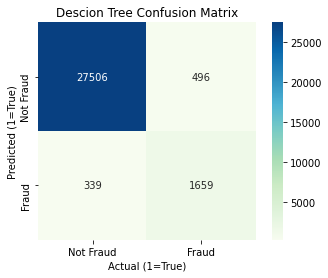

In [ ]:
# Create confusion matrix dataframe heatmap to see the predictions vs actuals
mat_LR = confusion_matrix(y_test, y_pred_LR.round())

# Plot the dataframe using heatmap, passing in the data and rendering settings, then adding the axis labels
sns.heatmap(mat_LR.T, square=True, annot=True, fmt='d', cmap='GnBu', cbar=True, xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Actual (1=True)')
plt.ylabel('Predicted (1=True)')
plt.title('Descion Tree Confusion Matrix');

### Decision Tree Classifier


In [ ]:
# Import the Descion Tree classifier and metrics libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
print('DescisionTreeClassifier and tree imported')

DescisionTreeClassifier and tree imported


In [ ]:
# Create Descion Tree classifier models and pass in the X and y training data sets

# Train the model using the training features (X_train) and the actual labels (y_train)
regressor = DecisionTreeClassifier() # No optimisation used in this first decision tree
regressor.fit(X_train, y_train)

# Pass in the test data and make the predictions using the 
y_pred_DT = regressor.predict(X_test)

# Create the accuracy scores for Mean Square Error and Root Mean Square Error
# Assign the accuracy for the Decision Tree to acc_DT
acc_DT = metrics.accuracy_score(y_test, y_pred_DT)
# Assign the MSE score for the Decision Tree to mse_DT
mse_DT = metrics.mean_squared_error(y_test, y_pred_DT)
# Assign the MSE score for the Decision Tree to rmse_DT
rmse_DT = np.sqrt(mse_DT)

In [ ]:
# Train a second Decision Tree with limited depth using the training features (X_train) and the actual labels (y_train)

# Limit (or 'prune') the number of branches in the tree using entropy and max_depth
regressorP = DecisionTreeClassifier(criterion="entropy", max_depth=10)
regressorP.fit(X_train, y_train)

# Pass in the test data and make the predictions using the 
y_pred_DTP = regressorP.predict(X_test)

# Create the accuracy scores for Mean Square Error and Root Mean Square Error
# Assign the accuracy for the Decision Tree to acc_DTP
acc_DTP = metrics.accuracy_score(y_test, y_pred_DTP)
# Assign the MSE score for the Decision Tree to mse_DTP
mse_DTP = metrics.mean_squared_error(y_test, y_pred_DTP)
# Assign the MSE score for the Decision Tree to rmse_DTP
rmse_DTP = np.sqrt(mse_DTP)

# Check the accuracy of the reults for each tree
print('Descision Tree classifier - Tree Depth:', regressor.tree_.max_depth, ' Accuracy:', 
      format(acc_DT, '.2%'), '  MSE:', round(mse_DT,3), '  RMSE:', round(rmse_DT,3))
print('Descision Tree classifier - Tree Depth:', regressorP.tree_.max_depth, '  Accuracy:', 
      format(acc_DTP, '.2%'), '  MSE:', round(mse_DTP,3), '  RMSE:', round(rmse_DTP,3))

Descision Tree classifier - Tree Depth: 26  Accuracy: 97.78%   MSE: 0.022   RMSE: 0.149
Descision Tree classifier - Tree Depth: 10   Accuracy: 98.68%   MSE: 0.013   RMSE: 0.115


By limiting the tree depth to 10, I found this increases the accuracy and reduced the MSE and RMSE scores.

In [ ]:
# Check the results for the standard tree
print("Single Tree Accuracy:", acc_DT)
print()

# Create a dataframe with the Actuals and Predictions
df_DT = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred_DT})
# Set the Predicted column as integer type
df_DT['Predicted'] = df_DT['Predicted'].astype(int)
# Create the results list for the table
# Note: results list for the table already exists as 'results'


# Group the data set by counting the number of values per column, add the results labels and re-order the columns
df_DT = df_DT.groupby(["Actual", "Predicted"]).size().reset_index(name="Count")
df_DT['Result'] = results 
df_DT = df_DT[["Result","Actual","Predicted","Count"]]
# Show the table
df_DT

Single Tree Accuracy: 0.9778



Result  Actual  Predicted  Count
0   True Negative       0          0  27474
1  False Positive       0          1    371
2  False Negative       1          0    295
3   True Positive       1          1   1860

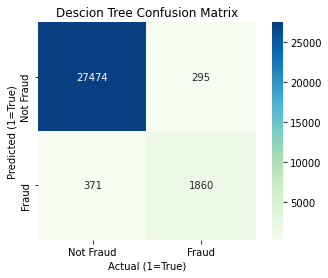

In [ ]:
# Create confusion matrix dataframe heatmap to see the predictions vs actuals
mat_dt = confusion_matrix(y_test, y_pred_DT.round())

# Plot the dataframe using heatmap, passing in the data and rendering settings, then adding the axis labels
sns.heatmap(mat_dt.T, square=True, annot=True, fmt='d', cmap='GnBu', cbar=True, xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Actual (1=True)')
plt.ylabel('Predicted (1=True)')
plt.title('Descion Tree Confusion Matrix');

In [ ]:
# Check the results for the optimised tree
print("Pruned Single Tree Accuracy:", acc_DTP)
print()

# Create a dataframe with the Actuals and Predictions
df_DTP = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred_DTP})
# Set the Predicted column as integer type
df_DTP['Predicted'] = df_DTP['Predicted'].astype(int)
# Note Results list for the table already exists as 'results'

# Group the data set by counting the number of values per column, add the results labels and re-order the columns
df_DTP = df_DTP.groupby(["Actual", "Predicted"]).size().reset_index(name="Count")
df_DTP['Result'] = results 
df_DTP = df_DTP[["Result","Actual","Predicted","Count"]]
# Show the table
df_DTP

Pruned Single Tree Accuracy: 0.9868333333333333



Result  Actual  Predicted  Count
0   True Negative       0          0  27805
1  False Positive       0          1     40
2  False Negative       1          0    355
3   True Positive       1          1   1800

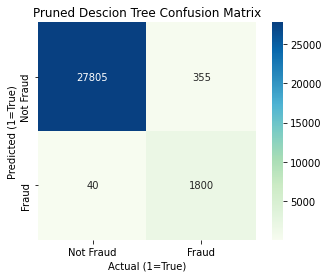

In [ ]:
# Create confusion matrix dataframe heatmap to see the predictions vs actuals
mat_dtp = confusion_matrix(y_test, y_pred_DTP.round())

# Plot the dataframe using heatmap, passing in the data and rendering settings, then adding the axis labels
sns.heatmap(mat_dtp.T, square=True, annot=True, fmt='d', cmap='GnBu', cbar=True, xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Actual (1=True)')
plt.ylabel('Predicted (1=True)')
plt.title('Pruned Descion Tree Confusion Matrix');

#### Plot the tree
The first tree is huge as it's >20 layers deep, so will display the second tree model which is limited to fewer layers.

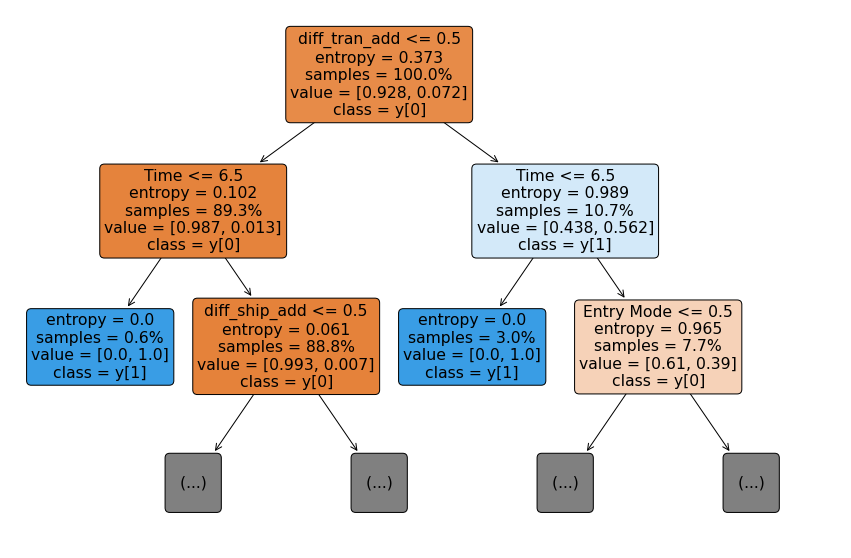

In [ ]:
# First let's look at the top 2 layers of the tree to see what's happening

# Set the plot size
fig = plt.figure(figsize=(15,10))

# Create the plot of the indicative descision tree
_ = tree.plot_tree(regressorP, max_depth=2,
                   feature_names=list(X.columns), proportion=True,
                   class_names=True, rounded=True,
                   filled=True)

In [ ]:
# Now plot the full tree
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus
print('Libraries imported')

Libraries imported


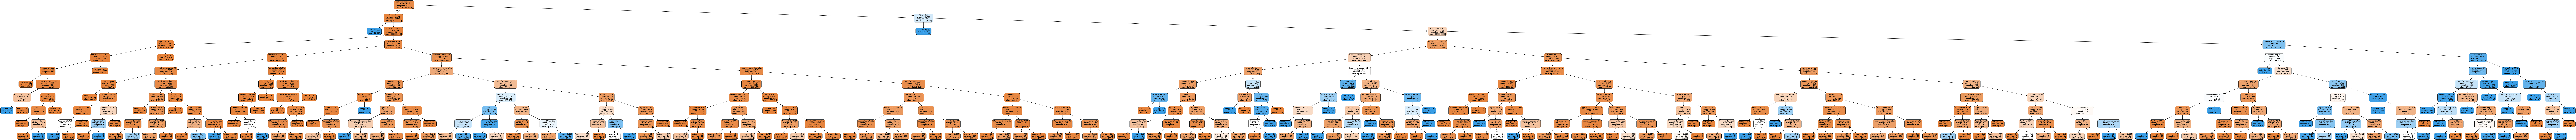

In [ ]:
# Set the parameters fort the chart
dot_data = StringIO()
feature_cols = list(X.columns) 
export_graphviz(regressorP, out_file=dot_data,filled=True,
                rounded=True,special_characters=True,
                feature_names=feature_cols)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('DescisionTree.png')
Image(graph.create_png())

Click on the above image to zoom in

### Bagging Classifier

The bagging classifier will take N number of random samples of the training data to learn from, which reduces the potential for over or under-fitting the model to the training data.

In [ ]:
# Import the bagging classifer model
from sklearn.ensemble import BaggingClassifier
print ('BaggingClassifier imported')

BaggingClassifier imported


In [ ]:
# Set the number of random samples to be used - this can be changed 
N = 50

# Fit the training data to the model
bagcl = BaggingClassifier(n_estimators=N, random_state=0)
bagcl.fit(X_train, y_train)
# Create an array with the predictions
y_pred_bag = bagcl.predict(X_test)

# Assign the scores to objects
acc_bag = metrics.accuracy_score(y_test, y_pred_bag)
mseBAG = metrics.mean_squared_error(y_test, y_pred_bag)
rmseBAG = np.sqrt(mseBAG)

print('Bagging Classifier - Accuracy:', format(acc_bag, '.2%'), '  MSE:', round(mseBAG,3), '  RMSE:', round(rmseBAG,3))

Bagging Classifier - Accuracy: 98.68%   MSE: 0.013   RMSE: 0.115


In [ ]:
# Check the results for the Bagging Classifier
print("Bagging", N, "- Tree Accuracy:", acc_bag)
print()

# Create a dataframe with the Actuals and Predictions
df_BAG = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred_bag})
# Set the Predicted column as integer type
df_BAG['Predicted'] = df_BAG['Predicted'].astype(int)
# Note Results list for the table already exists as 'results'

# Group the data set by counting the number of values per column, add the results labels and re-order the columns
df_BAG = df_BAG.groupby(["Actual", "Predicted"]).size().reset_index(name="Count")
df_BAG['Result'] = results 
df_BAG = df_BAG[["Result","Actual","Predicted","Count"]]
df_BAG

Bagging 50 - Tree Accuracy: 0.9868



Result  Actual  Predicted  Count
0   True Negative       0          0  27792
1  False Positive       0          1     53
2  False Negative       1          0    343
3   True Positive       1          1   1812

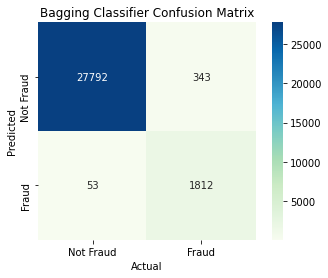

In [ ]:
# Create confusion matrix dataframe heatmap to see the predictions vs actuals
mat_bag = confusion_matrix(y_test, y_pred_bag.round())

# Plot the dataframe using heatmap, passing in the data and rendering settings, then adding the axis labels
sns.heatmap(mat_bag.T, square=True, annot=True, fmt='d', cbar=True, cmap='GnBu', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Bagging Classifier Confusion Matrix');

### Random Forest Classifier

In [ ]:
# Import the Random Forest model
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Fit the training data to the model
rfcl = RandomForestClassifier()
rfcl.fit(X_train, y_train)
# Create an array with the predictions
y_pred_RFC = rfcl.predict(X_test)

# Assign the scores to objects
acc_rfc = metrics.accuracy_score(y_test, y_pred_RFC)
mseRFC = metrics.mean_squared_error(y_test, y_pred_RFC)
rmseRFC = np.sqrt(mseRFC)

print('Random Forest - Accuracy:', format(acc_rfc, '.2%'), '  MSE:', round(mseRFC,3), '  RMSE:', round(rmseRFC,3))

Random Forest - Accuracy: 98.70%   MSE: 0.013   RMSE: 0.114


In [ ]:
# Show the accuracy score
print("Random Forest Classifier Accuracy:", acc_rfc)
print()

# Create a dataframe with the Actuals and Predictions
df_RFC = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred_RFC})
df_RFC['Predicted'] = df_RFC['Predicted'].astype(int)
# Set the Predicted column as integer type
# Note Results list for the table already exists as 'results'

# Group the data set by counting the number of values per column, add the results labels and re-order the columns
df_RFC = df_RFC.groupby(["Actual", "Predicted"]).size().reset_index(name="Count")
df_RFC['Result'] = results 
df_RFC = df_RFC[["Result","Actual","Predicted","Count"]]
df_RFC

Random Forest Classifier Accuracy: 0.9870333333333333



Result  Actual  Predicted  Count
0   True Negative       0          0  27803
1  False Positive       0          1     42
2  False Negative       1          0    347
3   True Positive       1          1   1808

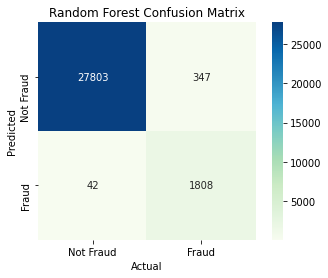

In [ ]:
# Create confusion matrix dataframe heatmap to see the predictions vs actuals
mat_rfc = confusion_matrix(y_test, y_pred_RFC.round())

# Plot the dataframe using heatmap, passing in the data and rendering settings, then adding the axis labels
sns.heatmap(mat_rfc.T, square=True, annot=True, fmt='d', cbar=True, cmap='GnBu', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Confusion Matrix');

### AdaBoost Classifier

In [ ]:
# Import the AdaBoost model
from sklearn.ensemble import AdaBoostClassifier
print('AdaBoostClassifier imported')

AdaBoostClassifier imported


In [ ]:
# Set the hyperparameters for the model
n_estimators = 50  # This is the number of 
learning_rate = 1  # This is the 

# Fit the training data to the model
ada = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=1)
ada.fit(X_train, y_train)
# Create an array with the predictions
y_pred_ADA = ada.predict(X_test)

# Assign the scores to objects
acc_ADA = metrics.accuracy_score(y_test, y_pred_ADA)
mseADA = metrics.mean_squared_error(y_test, y_pred_ADA)
rmseADA = np.sqrt(mseADA)

print('AdaBoost - Accuracy:', format(acc_ADA, '.2%'), '  MSE:', round(mseADA,3), '  RMSE:', round(rmseADA,3))

AdaBoost - Accuracy: 98.53%   MSE: 0.015   RMSE: 0.121


In [ ]:
# Show the accuracy score
print("AdaBoost Accuracy:", acc_ADA)
print()

# Create a dataframe with the Actuals and Predictions
df_ADA = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred_ADA})
# Set the Predicted column as integer type
df_ADA['Predicted'] = df_ADA['Predicted'].astype(int)
# Note Results list for the table already exists as 'results'

# Group the data set by counting the number of values per column, add the results labels and re-order the columns
df_ADA = df_ADA.groupby(["Actual", "Predicted"]).size().reset_index(name="Count")
df_ADA['Result'] = results 
df_ADA = df_ADA[["Result","Actual","Predicted","Count"]]
df_ADA

AdaBoost Accuracy: 0.9853



Result  Actual  Predicted  Count
0   True Negative       0          0  27679
1  False Positive       0          1    166
2  False Negative       1          0    275
3   True Positive       1          1   1880

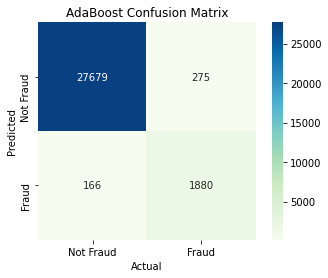

In [ ]:
# Create confusion matrix dataframe heatmap to see the predictions vs actuals
mat_ab = confusion_matrix(y_test, y_pred_ADA.round())

# Plot the dataframe using heatmap, passing in the data and rendering settings, then adding the axis labels
sns.figsize: (5, 5)
sns.heatmap(mat_ab.T, square=True, annot=True, fmt='d', cbar=True, cmap='GnBu', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('AdaBoost Confusion Matrix');

### Neural Network


In [ ]:
import tensorflow as tf
print('tensorflow imported')

tensorflow imported


In [ ]:
# First, set the Hyper parameters of the model
neurons = 64  # Number of neurons in the hidden layer, each is a regression equation
epochs = 10  # An epoch is one forward and backward training cycle of the training set, so the number here is how many times we run the training data through the model

# Create the model
nn1 = tf.keras.Sequential([
                             tf.keras.layers.Dense(neurons, activation='relu'),  # relu is the activation function for classification models; 0 unless the output of the neuron is positive
                             tf.keras.layers.Dense(neurons/2, activation='relu'),  # this is how many neurons are in the underlying layer
                             tf.keras.layers.Dropout(0.3),  # This drops 30% of the data randomly to avoid overfitting
                             tf.keras.layers.Dense(1, activation='sigmoid')])  # Sigmoid activiation is used for binary classifications

nn1.compile(loss = 'mse',
              optimizer = 'adam',  # adaptive moment - used in the gradient decent in the model
              metrics=['accuracy'])

# Fit the training data to the model using the number of epochs defined above
nn1.fit(X_train, y_train, epochs=epochs).history
y_pred_NN1 = nn1.predict(X_test)

# Convert all the outputs to booleans (just makes it easier to see)
threshold = 0.5
y_pred_NN1 = nn1.predict(X_test)
y_pred_NN1 = y_pred_NN1 > threshold
y_pred_NN1 = y_pred_NN1.flatten()

# Assign the scores to objects
acc_NN1 = metrics.accuracy_score(y_test, y_pred_NN1)
mseNN1 = metrics.mean_squared_error(y_test, y_pred_NN1)
rmseNN1 = np.sqrt(mseNN1)

print('NN1 - Accuracy:', format(acc_NN1, '.2%'), '  MSE:', round(mseNN1,3), '  RMSE:', round(rmseNN1,3))

Epoch 1/10
2188/2188 [==============================] - 3s 1ms/step - loss: 0.0477 - accuracy: 0.9400
Epoch 2/10
2188/2188 [==============================] - 3s 1ms/step - loss: 0.0183 - accuracy: 0.9770
Epoch 3/10
2188/2188 [==============================] - 3s 1ms/step - loss: 0.0167 - accuracy: 0.9789
Epoch 4/10
2188/2188 [==============================] - 3s 1ms/step - loss: 0.0150 - accuracy: 0.9811
Epoch 5/10
2188/2188 [==============================] - 3s 1ms/step - loss: 0.0146 - accuracy: 0.9813
Epoch 6/10
2188/2188 [==============================] - 3s 1ms/step - loss: 0.0142 - accuracy: 0.9824
Epoch 7/10
2188/2188 [==============================] - 3s 1ms/step - loss: 0.0137 - accuracy: 0.9831
Epoch 8/10
2188/2188 [==============================] - 3s 1ms/step - loss: 0.0123 - accuracy: 0.9849
Epoch 9/10
2188/2188 [==============================] - 3s 1ms/step - loss: 0.0131 - accuracy: 0.9838
Epoch 10/10
2188/2188 [==============================] - 3s 1ms/step - loss: 0.012

In [ ]:
# Summarise the details of the model with 10 epochs
nn1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                832       
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Check the acuracy of the model
print("Neural Network Accuracy:", acc_NN1)
print()

# Create a dataframe with the Actuals and Predictions
df_NN1 = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred_NN1})
# Set the Predicted column as integer type
df_NN1['Predicted'] = df_NN1['Predicted'].astype(int)

# Group the data set by counting the number of values per column, add the results labels and re-order the columns
df_NN1 = df_NN1.groupby(["Actual", "Predicted"]).size().reset_index(name="Count")
df_NN1['Result'] = results 
df_NN1 = df_NN1[["Result","Actual","Predicted","Count"]]
df_NN1.head()

Neural Network Accuracy: 0.9830666666666666



Result  Actual  Predicted  Count
0   True Negative       0          0  27721
1  False Positive       0          1    124
2  False Negative       1          0    384
3   True Positive       1          1   1771

In [ ]:
# # Create charts that show the model accuracy over time
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
# axes[0].plot(nn1.history.history['accuracy'], label='accuracy', color='red')
# axes[1].plot(nn1.history.history['loss'], label='loss', color='blue')
# # Add titles and axis lables
# axes[0].set_xlabel('Epochs')
# axes[0].title.set_text('Model Accuracy')
# axes[1].set_xlabel('Epochs')
# axes[1].title.set_text('Model Loss: MSE')

# This chart intended to show how the accuracy improved over time but is erroring on the history section

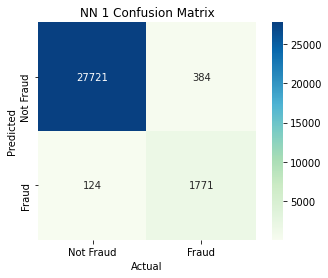

In [ ]:
# Create confusion matrix dataframe heatmap to see the predictions vs actuals
mat_nn1 = confusion_matrix(y_test, y_pred_NN1.round())

# Plot the dataframe using heatmap, passing in the data and rendering settings, then adding the axis labels
sns.heatmap(mat_nn1.T, square=True, annot=True, fmt='d', cbar=True, cmap='GnBu', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('NN 1 Confusion Matrix');

The Neural Network may produce better results using more epochs, so this will be increased and re-run to test this theory

In [ ]:
# Model Hyperparameters
neurons = 64
epochs = 25  #  Inrease from 10 to 25 

# Create the model
nn2 = tf.keras.Sequential([
                             tf.keras.layers.Dense(neurons, activation='relu'),
                             tf.keras.layers.Dense(neurons/2, activation='relu'),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(1, activation='sigmoid')])

nn2.compile(loss = 'mse',
              optimizer = 'adam',
              metrics=['accuracy'])

# Fit the training data to the model
nn2.fit(X_train, y_train, epochs=epochs)
y_pred_NN2 = nn2.predict(X_test)

threshold = 0.5

# Create the prediction and update it using the threshold parameter
y_pred_NN2 = nn2.predict(X_test)
y_pred_NN2 = y_pred_NN2 > threshold
y_pred_NN2 = y_pred_NN2.flatten()

# Assign the scores to objects
acc_NN2 = metrics.accuracy_score(y_test, y_pred_NN2)
mse_NN2 = metrics.mean_squared_error(y_test, y_pred_NN2)
rmse_NN2 = np.sqrt(mse_NN2)

print('Accuracy:', format(acc_NN2, '.2%'), '  MSE:', round(mse_NN2,3), '  RMSE:', round(rmse_NN2,3))

Epoch 1/25
2188/2188 [==============================] - 3s 1ms/step - loss: 0.0453 - accuracy: 0.9453
Epoch 2/25
2188/2188 [==============================] - 3s 1ms/step - loss: 0.0184 - accuracy: 0.9759
Epoch 3/25
2188/2188 [==============================] - 3s 1ms/step - loss: 0.0171 - accuracy: 0.9782
Epoch 4/25
2188/2188 [==============================] - 3s 1ms/step - loss: 0.0158 - accuracy: 0.9797
Epoch 5/25
2188/2188 [==============================] - 3s 1ms/step - loss: 0.0147 - accuracy: 0.9816
Epoch 6/25
2188/2188 [==============================] - 3s 1ms/step - loss: 0.0141 - accuracy: 0.9823
Epoch 7/25
2188/2188 [==============================] - 3s 1ms/step - loss: 0.0133 - accuracy: 0.9837
Epoch 8/25
2188/2188 [==============================] - 3s 1ms/step - loss: 0.0131 - accuracy: 0.9836
Epoch 9/25
2188/2188 [==============================] - 3s 1ms/step - loss: 0.0136 - accuracy: 0.9831
Epoch 10/25
2188/2188 [==============================] - 3s 1ms/step - loss: 0.012

In [ ]:
# Summarise the details of the model with 15 epochs
nn2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                832       
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Check the acuracy of the model
print("Neural Network Accuracy:", acc_NN2)
print()

# Create a dataframe with the Actuals and Predictions
df_NN2 = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred_NN2})
# Set the Predicted column as integer type
df_NN2['Predicted'] = df_NN2['Predicted'].astype(int)
# Note Results list for the table already exists as 'results'

# Group the data set by counting the number of values per column, add the results labels and re-order the columns
df_NN2 = df_NN2.groupby(["Actual", "Predicted"]).size().reset_index(name="Count")
df_NN2['Result'] = results 
df_NN2 = df_NN2[["Result","Actual","Predicted","Count"]]
df_NN2.head()

Neural Network Accuracy: 0.9847



Result  Actual  Predicted  Count
0   True Negative       0          0  27795
1  False Positive       0          1     50
2  False Negative       1          0    409
3   True Positive       1          1   1746

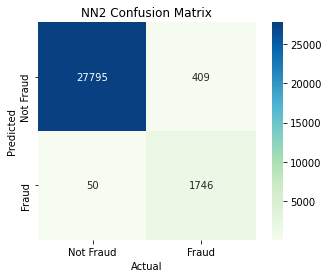

In [ ]:
# Create confusion matrix dataframe heatmap to see the predictions vs actuals
mat_nn2 = confusion_matrix(y_test, y_pred_NN2.round())

# Plot the dataframe using heatmap, passing in the data and rendering settings, then adding the axis labels
sns.heatmap(mat_nn2.T, square=True, annot=True, fmt='d', cbar=True, cmap='GnBu', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('NN2 Confusion Matrix');

## XGBoost

In [ ]:
# Import the xgboost library
import xgboost as xgb
print('xgboost imported')

xgboost imported


In [ ]:
# Fit the training data to the model
xgcl = xgb.XGBClassifier(objective ='reg:squarederror',
                         colsample_bytree = 0.3,
                         learning_rate = 0.1,  # A small learning rate means it may take longer but has a better chance of converging on the minimum error
                         alpha = 10,
                         n_estimators = 20)
xgcl.fit(X_train, y_train)

# Create an array with the predictions
y_pred_xgcl = xgcl.predict(X_test)

# Convert all the outputs to booleans (just makes it easier to see)
threshold = 0.5
y_pred_xgcl = nn1.predict(X_test)
y_pred_xgcl = y_pred_xgcl > threshold
y_pred_xgcl = y_pred_xgcl.flatten()

# Assign the scores to objects
acc_xgcl = metrics.accuracy_score(y_test, y_pred_xgcl)
mse_xgcl = metrics.mean_squared_error(y_test, y_pred_xgcl)
rmse_xgcl = np.sqrt(mse_xgcl)

print('XGBoost - Accuracy:', format(acc_xgcl, '.2%'), ' MSE:', round(mse_xgcl,3), ' RMSE:', round(rmse_xgcl,3))

XGBoost - Accuracy: 98.31%  MSE: 0.017  RMSE: 0.13


In [ ]:
# Show the accuracy score
print("XGBoost Accuracy:", acc_xgcl)
print()

# Create a dataframe with the Actuals and Predictions
df_xgcl = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred_xgcl})
# Set the Predicted column as integer type
df_xgcl['Predicted'] = df_xgcl['Predicted'].astype(int)
# Note Results list for the table already exists as 'results'

# Group the data set by counting the number of values per column, add the results labels and re-order the columns
df_xgcl = df_xgcl.groupby(["Actual", "Predicted"]).size().reset_index(name="Count")
#df_xgcl['Result'] = results 
#df_xgcl = df_xgcl[["Result","Actual","Predicted","Count"]]
df_xgcl

XGBoost Accuracy: 0.9830666666666666



Actual  Predicted  Count
0       0          0  27721
1       0          1    124
2       1          0    384
3       1          1   1771

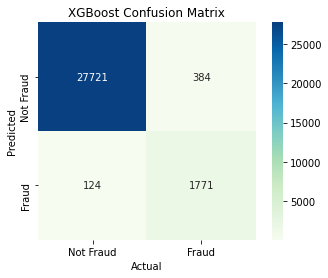

In [ ]:
# Create confusion matrix dataframe heatmap to see the predictions vs actuals
mat_xgcl = confusion_matrix(y_test, y_pred_xgcl.round())

# Plot the dataframe using heatmap, passing in the data and rendering settings, then adding the axis labels
sns.figsize: (5, 5)
sns.heatmap(mat_xgcl.T, square=True, annot=True, fmt='d', cbar=True, cmap='GnBu', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGBoost Confusion Matrix');

# Model Evaluation

### Comparisons of Results

In [ ]:
# Number of incorrect classifications
# converted to strings for aesthetics

LR_wrong = (df_LR['Count'][1] + df_LR['Count'][2])
DTP_wrong = (df_DTP['Count'][1] + df_DTP['Count'][2])
BAG_wrong = (df_BAG['Count'][1] + df_BAG['Count'][2])
RFC_wrong = (df_RFC['Count'][1] + df_RFC['Count'][2])
ADA_wrong = (df_ADA['Count'][1] + df_ADA['Count'][2])
NN1_wrong = (df_NN1['Count'][1] + df_NN1['Count'][2])
NN2_wrong = (df_NN2['Count'][1] + df_NN2['Count'][2])
XGB_wrong = (df_xgcl['Count'][1] + df_xgcl['Count'][2])

In [ ]:
LR_right = (df_LR['Count'][0] + df_LR['Count'][3])
DTP_right = (df_DTP['Count'][0] + df_DTP['Count'][3])
BAG_right = (df_BAG['Count'][0] + df_BAG['Count'][3])
RFC_right = (df_RFC['Count'][0] + df_RFC['Count'][3])
ADA_right = (df_ADA['Count'][0] + df_ADA['Count'][3])
NN1_right = (df_NN1['Count'][0] + df_NN1['Count'][3])
NN2_right = (df_NN2['Count'][0] + df_NN2['Count'][3])
XGB_right = (df_xgcl['Count'][0] + df_xgcl['Count'][3])

In [ ]:
data = {'Logistic Regression': [acc_LR, LR_right, LR_wrong, rmseLR],
        'Decision Tree': [acc_DTP, DTP_right, DTP_wrong, rmse_DTP], 
        'Bagging':[acc_bag, BAG_right, BAG_wrong, rmseBAG], 
        'Random Forest': [acc_rfc, RFC_right, RFC_wrong, rmseRFC],
        'AdaBoost': [acc_ADA, ADA_right, ADA_wrong, rmseADA],
        'Neural Network 1': [acc_NN1, NN1_right, NN1_wrong, rmseNN1],
        'Neural Network 2': [acc_NN2, NN2_right, NN2_wrong, rmse_NN2],
        'XGBoost': [acc_xgcl, XGB_right, XGB_wrong, rmse_xgcl]}
  
df_comp = pd.DataFrame(data) 
df_comp = df_comp.rename(index={0 : 'Model Accuracy', 1 : 'Correct Classifications', 2 : 'Incorrect Classifications', 3 : 'RMSE'})

df_comp

Logistic Regression  ...       XGBoost
Model Accuracy                        0.972167  ...      0.983067
Correct Classifications           29165.000000  ...  29492.000000
Incorrect Classifications           835.000000  ...    508.000000
RMSE                                  0.166833  ...      0.130128

[4 rows x 8 columns]

The BaggingClassifier and RandomForestClassifier had the most accurate predictions overall.

## Visualisation

### Arrange the data in to a visually asthetic table and also a table format for creating charts  

In [ ]:
# Set up the data frame for visualistion

# Transposes the data to align scores in to columns by model
df_compt = df_comp.T  
df_compt['Correct Classifications'] = df_compt['Correct Classifications'].astype(int)
df_compt['Incorrect Classifications'] = df_compt['Incorrect Classifications'].astype(int)
df_compt.head()

Model Accuracy  ...      RMSE
Logistic Regression        0.972167  ...  0.166833
Decision Tree              0.986833  ...  0.114746
Bagging                    0.986800  ...  0.114891
Random Forest              0.987033  ...  0.113871
AdaBoost                   0.985300  ...  0.121244

[5 rows x 4 columns]

In [ ]:
# Create a copy of the table and add the index to the new table
df_comp3 = df_compt
# Sort the values by # of correct classifications
df_comp3.sort_values(by=['Correct Classifications'], ascending=False, inplace=True)

# Reset the index
df_comp3.reset_index(inplace=True)

# Rename the index column to 'Model'
df_comp3.rename(columns={'index': 'Model'}, inplace=True)
df_comp3

Model  Model Accuracy  ...  Incorrect Classifications      RMSE
0        Random Forest        0.987033  ...                        389  0.113871
1        Decision Tree        0.986833  ...                        395  0.114746
2              Bagging        0.986800  ...                        396  0.114891
3             AdaBoost        0.985300  ...                        441  0.121244
4     Neural Network 2        0.984700  ...                        459  0.123693
5     Neural Network 1        0.983067  ...                        508  0.130128
6              XGBoost        0.983067  ...                        508  0.130128
7  Logistic Regression        0.972167  ...                        835  0.166833

[8 rows x 5 columns]

### Create Charts to compare models

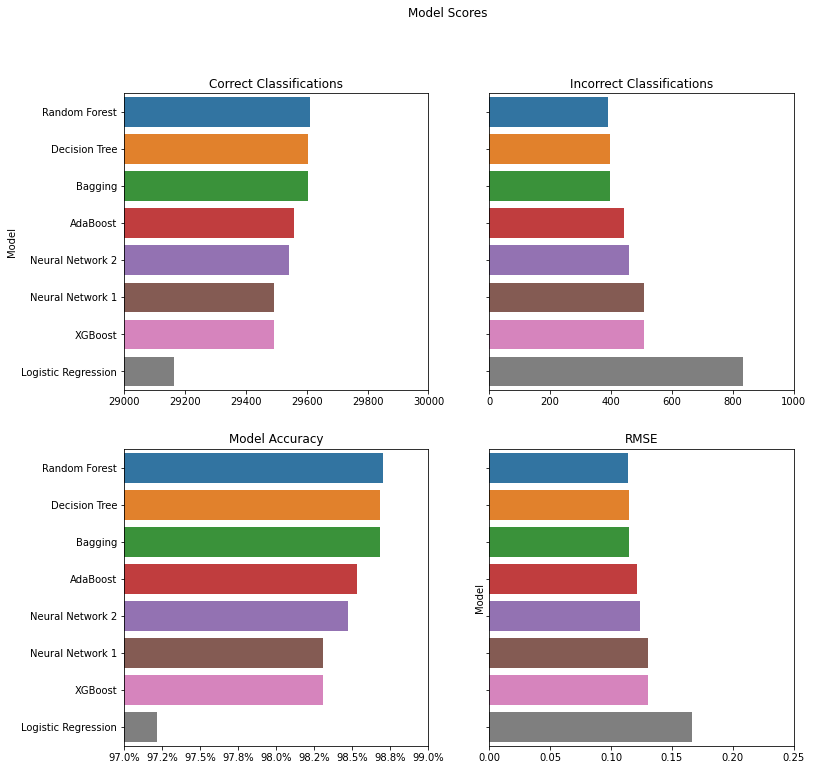

In [ ]:
# Import the ticker library for formating chart axes
import matplotlib.ticker as mtick

# Create the subplots
fig, axs = plt.subplots(2,2, figsize=(12, 12), sharey=True)

# Create the 4 charts and their resective positions on the figure 
sns.barplot(y='Model', x='Correct Classifications', data=df_comp3, ax=axs[0,0])
sns.barplot(y='Model', x='Incorrect Classifications', data=df_comp3, ax=axs[0,1])
sns.barplot(y='Model', x='Model Accuracy', data=df_comp3, ax=axs[1,0])
sns.barplot(y='Model', x='RMSE', data=df_comp3, ax=axs[1,1])

# Set the axis start and end values so it's easier to see the variation
axs[0,0].set_xlim(29000,30000)
axs[0,1].set_xlim(0,1000)
axs[1,0].set_xlim(.97,.99)
axs[1,1].set_xlim(0,.25)

# Argument 1 sets the value that corresponds to 100% on the axis (which as above is .99), argument 2 sets the number of deciamls to display on the axis labels
axs[1,0].xaxis.set_major_formatter(mtick.PercentFormatter(1,1))

# Add chart titles for each histogram
axs[0,0].set_title('Correct Classifications')
axs[0,1].set_title('Incorrect Classifications')
axs[1,0].set_title('Model Accuracy')
axs[1,1].set_title('RMSE')

axs[0,0].xaxis.label.set_visible(False)
axs[0,1].xaxis.label.set_visible(False)
axs[1,0].xaxis.label.set_visible(False)
axs[1,1].xaxis.label.set_visible(False)

axs[0,1].yaxis.label.set_visible(False)
axs[1,0].yaxis.label.set_visible(False)

fig.suptitle('Model Scores')
plt.show();

From the results, Random Forest scored the highest number of accurate predictions.  Logistic Regression performed the worst.  The Decision tree and Bagging models were very close to the Random Forest, but the next check is how each model performed at correctly predicting the true Fraud values, so the confusion matrices will help understand this split.

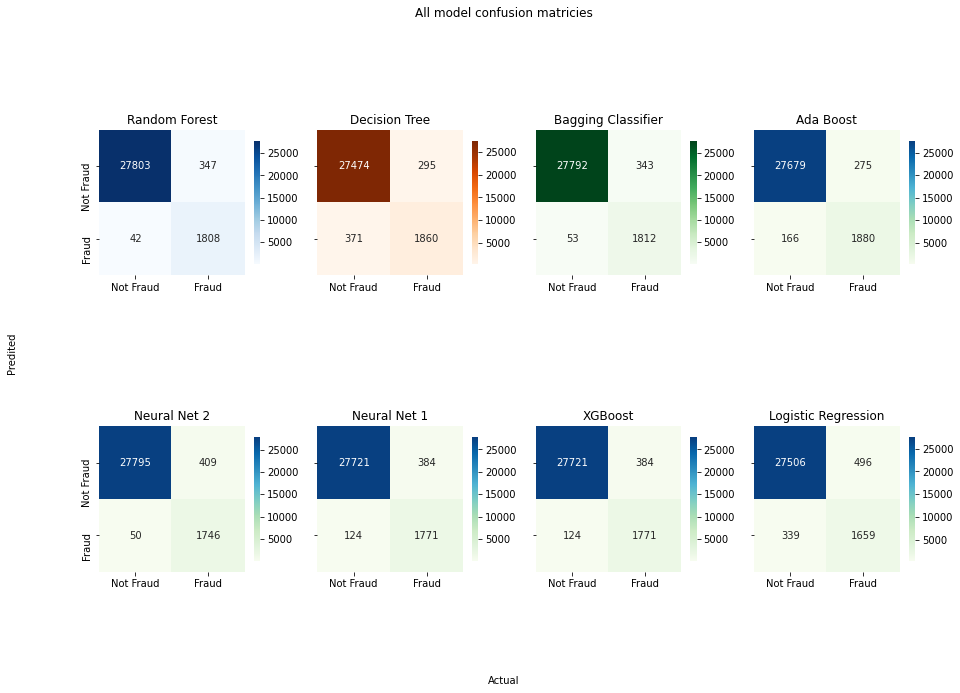

In [ ]:
# Build a plot shoiwing all confusion matrices

# Set up the 2x3 chart subplots and size, use constrained layout to ensure lables do not overlap
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,10), sharex=False, sharey=True)

sns.heatmap(data=mat_rfc.T, square=True, annot=True, fmt='d', cmap='Blues', cbar=True, cbar_kws={"shrink": 0.5}, xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'], ax=axs[0,0])
sns.heatmap(data=mat_dt.T, square=True, annot=True, fmt='d', cmap='Oranges', cbar=True, cbar_kws={"shrink": 0.5},  xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'], ax=axs[0,1])
sns.heatmap(data=mat_bag.T, square=True, annot=True, fmt='d', cmap='Greens', cbar=True, cbar_kws={"shrink": 0.5}, xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'], ax=axs[0,2])
sns.heatmap(data=mat_ab.T, square=True, annot=True, fmt='d', cmap='GnBu', cbar=True, cbar_kws={"shrink": 0.5}, xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'], ax=axs[0,3])
sns.heatmap(data=mat_nn2.T, square=True, annot=True, fmt='d', cmap='GnBu', cbar=True, cbar_kws={"shrink": 0.5}, xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'], ax=axs[1,0])
sns.heatmap(data=mat_nn1.T, square=True, annot=True, fmt='d', cmap='GnBu', cbar=True, cbar_kws={"shrink": 0.5}, xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'], ax=axs[1,1])
sns.heatmap(data=mat_xgcl.T, square=True, annot=True, fmt='d', cmap='GnBu', cbar=True, cbar_kws={"shrink": 0.5},  xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'], ax=axs[1,2])
sns.heatmap(data=mat_LR.T, square=True, annot=True, fmt='d', cmap='GnBu', cbar=True, cbar_kws={"shrink": 0.5},  xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'], ax=axs[1,3])

# Add chart titles for each histogram
axs[0,0].set_title('Random Forest')
axs[0,1].set_title('Decision Tree')
axs[0,2].set_title('Bagging Classifier')
axs[0,3].set_title('Ada Boost')
axs[1,0].set_title('Neural Net 2')
axs[1,1].set_title('Neural Net 1')
axs[1,2].set_title('XGBoost')
axs[1,3].set_title('Logistic Regression')

# axs[0,0].xaxis.label.set_visible(True)
# axs[0,1].xaxis.label.set_visible(True)
# axs[1,0].xaxis.label.set_visible(True)
# axs[1,1].xaxis.label.set_visible(True)

fig.text(0.5, 0.04, 'Actual', ha='center')
fig.text(0.04, 0.5, 'Predited', va='center', rotation='vertical')

fig.suptitle('All model confusion matricies')

#fig.tight_layout()
plt.show();

The AdaBoost model was the most accurate at predicting the Fraud value. Depending on the company's view of balancing incurred fraud with that of customer satisfaction, this may be the best option. Otherwise, they may prefer to take the hit on some fraud and use the Random Forest or Bagging classifier as these have fewer false positives, so would cause less valid customer transactions to be declined.